<a href="https://colab.research.google.com/github/VasylVasylenko/trash_demo/blob/main/solve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
print(sys.executable)

/Users/vasylvasylenko/opt/anaconda3/bin/python


In [ ]:
from abc import ABC, abstractmethod
from typing import Callable

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.spatial import ConvexHull
from scipy.spatial.qhull import _Qhull

In [ ]:
def G(R: np.ndarray, R0: np.ndarray) -> np.ndarray:
    """
    Green's function:
    ```
        G(R; R0) = [
            [(-x^2 + y^2) / (2 * Pi * (x^2 + y^2) ^ 2), -xy / (Pi * (x^2 + y^2) ^ 2)],
            [-xy / (Pi * (x^2 + y^2) ^ 2), (x^2 - y^2) / (2 * Pi * (x^2 + y^2) ^ 2)]
        ],
    ```
    where `(x, y) = R - R0`.

    @param R: input array of shape (..., 2)
    @param R0: input array of shape (..., 2)
    @return: green's function values array of shape (2, 2, ...)
    """
    if not isinstance(R, np.ndarray):
        R = np.array(R)
    if not isinstance(R0, np.ndarray):
        R0 = np.array(R0)
    assert len(R.shape) == len(R0.shape), f"Different axes numbers: {len(R.shape)} != {len(R0.shape)}"
    delta_R = R - R0
    delta_R2 = delta_R * delta_R                       # [x, y]
    denom = np.pi * np.sum(delta_R2, axis=-1) ** 2     # Pi * (x^2 + y^2) ^ 2
    x2_minus_y2 = delta_R2[..., 0] - delta_R2[..., 1]  # x^2 - y^2
    neg_xy = -delta_R[..., 0] * delta_R[..., 1]        # -xy
    mat = np.array([
        [-x2_minus_y2 / 2, neg_xy],
        [neg_xy, x2_minus_y2 / 2]
    ])
    G_mat = np.zeros_like(mat)
    mask = denom != 0
    G_mat[:, :, mask] = mat[:, :, mask] / denom[np.newaxis, np.newaxis][:, :, mask]
    return G_mat

In [ ]:
class Xi(ABC):
    @abstractmethod
    def apply(self, R: np.ndarray) -> np.ndarray:
        pass

    def __call__(self, R: np.ndarray) -> np.ndarray:
        if not isinstance(R, np.ndarray):
            R = np.array(R)
        res: np.ndarray = self.apply(R)
        assert res.shape == R.shape[:-1], res.shape
        return res

    def __repr__(self) -> str:
        return f"[{self.__class__.__name__}]"

    def __str__(self) -> str:
        return repr(self)


class SquareXi(Xi):
    def __init__(self, a1: float, a2: float, b1: float, b2: float):
        assert a1 < a2 and b1 < b2, f"a1={a1}, a2={a2}, b1={b1}, b2={b2}"
        self.a1: float = a1
        self.a2: float = a2
        self.b1: float = b1
        self.b2: float = b2

    def __repr__(self) -> str:
        return f"[{self.__class__.__name__}] a1={self.a1}, a2={self.a2}, b1={self.b1}, b2={self.b2}"

    def apply(self, R: np.ndarray) -> np.ndarray:
        return (R[..., 0] >= self.a1) & (R[..., 0] <= self.a2) & (R[..., 1] >= self.b1) & (R[..., 1] <= self.b2)


class ElipseXi(Xi):
    def __init__(self, x0: np.ndarray, a: float, b: float):
        if not isinstance(x0, np.ndarray):
            x0 = np.array(x0)
        assert len(x0.shape) == 1, f"Unexpected dimensionality: x0.shape={x0.shape}"
        assert a > 0, f"Radius = {a} < 0"
        assert b > 0, f"Radius = {b} < 0"
        self.x0: np.ndarray = x0
        self.a: float = a
        self.b: float = b

    def __repr__(self) -> str:
        return f"[{self.__class__.__name__}] Center={self.x0}, a={self.a}, b={self.b}"

    def apply(self, R: np.ndarray) -> np.ndarray:
        return np.sum((R - self.x0) ** 2 / np.array([self.a, self.b])**2, axis=-1) <= 1
    
    
class CircleXi(Xi):
    def __init__(self, x0: np.ndarray, r: float):
        if not isinstance(x0, np.ndarray):
            x0 = np.array(x0)
        assert len(x0.shape) == 1, f"Unexpected dimensionality: x0.shape={x0.shape}"
        assert r > 0, f"Radius = {r} < 0"
        self.x0: np.ndarray = x0
        self.r: float = r

    def __repr__(self) -> str:
        return f"[{self.__class__.__name__}] Center={self.x0}, Radius={self.r}"

    def apply(self, R: np.ndarray) -> np.ndarray:
        return np.sum((R - self.x0) ** 2, axis=-1) <= self.r ** 2
    
def in_hull(points, queries):
    hull = _Qhull(b"i", points,
                  options=b"",
                  furthest_site=False,
                  incremental=False, 
                  interior_point=None)
    equations = hull.get_simplex_facet_array()[2].T
    return np.all(queries @ equations[:-1] < - equations[-1], axis=1)


    
class ConvexPolyXi(Xi):
    def __init__(self, p: np.ndarray):
        if not isinstance(p, np.ndarray):
            p = np.array(p)
        assert p.shape[-1] == 2, f"Unexpected dimensionality: p.shape[-1]={p.shape}"
        self.p: np.ndarray = p

    def __repr__(self) -> str:
        return f"[{self.__class__.__name__}] Points={self.x0}"

    def apply(self, R: np.ndarray) -> np.ndarray:
        return in_hull(self.p, R)
    
class SumXi(Xi):
    def __init__(self, *arr):
        self.arr=list(arr)

    def __repr__(self) -> str:
        return f"[{self.__class__.__name__}"

    def apply(self, R: np.ndarray) -> np.ndarray:
        res=self.arr[0].apply(R)
        for xi in self.arr[1:]:
            res = np.logical_or(res, xi.apply(R))
            
        return res

In [ ]:
class E_Ext_Class(ABC):
    @abstractmethod
    def apply(self, R: np.ndarray) -> np.ndarray:
        pass

    def __call__(self, R: np.ndarray) -> np.ndarray:
        if not isinstance(R, np.ndarray):
            R = np.array(R)
        res: np.ndarray = self.apply(R)
        assert res.shape[1:] == R.shape[:-1] and res.shape[0] == R.shape[-1], res.shape
        return res

    def __repr__(self) -> str:
        return f"[{self.__class__.__name__}]"

    def __str__(self) -> str:
        return repr(self)


class E_Ext_Const(E_Ext_Class):
    def __init__(self, const_E: np.ndarray):
        if not isinstance(const_E, np.ndarray):
            const_E = np.array(const_E)
        assert len(const_E.shape) == 1, f"Unexpected shape {const_E.shape}"
        self.const_E: np.ndarray = const_E

    def apply(self, R: np.ndarray) -> np.ndarray:
        E_ext: np.ndarray = np.empty((self.const_E.shape[0],) + R.shape[:-1], dtype=self.const_E.dtype)
        for ix, e_val in enumerate(self.const_E):
            E_ext[ix] = e_val
        return E_ext

In [ ]:
def create_A(G_mat: np.ndarray, delta_mat: np.ndarray) -> np.ndarray:
    # Note: `Xi(R_j) == 1`, otherwise `Xi_mul: np.ndarray = Xi_mat.reshape(1, 1, 1, -1)`
    Xi_mul: float = 1

    # ```M[:, :, i, j] = G(R_j, R_i) * Xi(R_j) * delta_j```
    # Note: `G(R_j, R_i)` is a matrix
    M: np.ndarray = G_mat * Xi_mul * delta_mat.reshape(1, 1, 1, -1)

    # Final matrix A
    A = np.eye(2 * G_mat.shape[-1]) + M.transpose((0, 2, 1, 3)).reshape(2 * G_mat.shape[-1], 2 * G_mat.shape[-1])
    return A

In [ ]:
def calc_E_on_grid(Nx: int, Ny: int, xy_grid: np.ndarray, xy_grid_non_zero: np.ndarray,
                   Xi_mat: np.ndarray, delta_mat: np.ndarray, E_sol: np.ndarray,
                   E_ext: Callable[[np.ndarray], np.ndarray]) -> np.ndarray:
    # Calculate required Green's function values
    G_mat: np.ndarray = G(xy_grid_non_zero[np.newaxis, :, :], xy_grid[:, np.newaxis, :])

    # Note: `Xi(R_j) == 1`, otherwise `Xi_mul: np.ndarray = Xi_mat.reshape(1, 1, 1, -1)`
    Xi_mul: float = 1

    # ```G_mat_E_sol_prod[:, i, j] = G(R_j, R_i) * E(R_j)```
    G_mat_E_sol_prod: np.ndarray = np.sum(G_mat * E_sol[np.newaxis, :, np.newaxis, :], axis=1)

    # ```integral_val[:, i] = Integrate[G(R_j, R_i) * Xi(R_j) * E(R_j) dR_j]```
    # Note: `G(R_j, R_i)` is a matrix
    integral_val: np.ndarray = np.sum(G_mat_E_sol_prod * Xi_mul * delta_mat.reshape(1, 1, -1), axis=-1)

    # ```E(R_i) = E^(ext) - Integrate[G(R_j, R_i) * Xi(R_j) * E(R_j) dR_j]```
    E_arr: np.ndarray = E_ext(xy_grid) - integral_val

    return xy_grid.reshape(Ny, Nx, -1).transpose((2, 0, 1)), E_arr.reshape(-1, Ny, Nx)

In [ ]:
#xi_fn: Xi = CircleXi([0, 0], 0.1)
#xi_fn: Xi = SquareXi(-0.1, 0.1, -0.1, 0.1)
#xi_fn: Xi = ElipseXi([0, 0], 0.1, 0.05)
#xi_fn: Xi = ConvexPolyXi([[0, 0.1], [0.1,-0.1], [-0.1,-0.1]],)
xi_fn: Xi = SumXi(CircleXi([-0.12, 0], 0.1), ConvexPolyXi([[0.12, 0.1], [0.22,-0.1], [0.02,-0.1]]),
                  SquareXi(-0.1, 0.1, -0.35, -0.15))


E_ext: E_Ext_Class = E_Ext_Const([1, 1])

Nx: int = 100
Ny: int = 100

x1, x2 = -0.5, 0.5
y1, y2 = -0.5, 0.5

In [ ]:
xy_grid: np.ndarray = np.stack(np.meshgrid(np.linspace(x1, x2, Nx), np.linspace(y1, y2, Ny)),
                               axis=-1).reshape(-1, 2)
xy_grid.shape, xy_grid.dtype

((10000, 2), dtype('float64'))

In [ ]:
np.stack(np.meshgrid(np.linspace(x1, x2, Nx), np.linspace(y1, y2, Ny)),
                               axis=-1)[1, 0]

array([-0.5       , -0.48989899])

In [ ]:
Xi_mat: np.ndarray = xi_fn(xy_grid)
print("Non zero elements:", np.count_nonzero(Xi_mat))
Xi_mat.shape, Xi_mat.dtype

Non zero elements: 910


((10000,), dtype('bool'))

In [ ]:
xy_grid_non_zero: np.ndarray = xy_grid[Xi_mat]
N: int = xy_grid_non_zero.shape[0]
xy_grid_non_zero.shape, xy_grid_non_zero.dtype

((910, 2), dtype('float64'))

In [ ]:
G_mat: np.ndarray = G(xy_grid_non_zero[np.newaxis, :, :], xy_grid_non_zero[:, np.newaxis, :])
G_mat.shape

(2, 2, 910, 910)

In [ ]:
delta: float = (x2 - x1) / Nx * (y2 - y1) / Ny
delta_mat: np.ndarray = np.ones((xy_grid_non_zero.shape[0],), dtype=np.float64) * delta
delta_mat.shape

(910,)

In [ ]:
E_ext_mat: np.ndarray = E_ext(xy_grid_non_zero)
E_ext_mat.shape

(2, 910)

In [ ]:
A: np.ndarray = create_A(G_mat, delta_mat)
b: np.ndarray = E_ext_mat.reshape(-1, 1)
A.shape, b.shape

((1820, 1820), (1820, 1))

# Calculate solution using peudo-inverse matrix by Moore-Penrose

In [ ]:
# Simple solution, but may be not accurate when A has bad condition number
A_pinv: np.ndarray = np.linalg.pinv(A)
E_sol_1: np.ndarray = np.matmul(A_pinv, b)
E_sol_1 = E_sol_1.reshape(-1, xy_grid_non_zero.shape[0])
E_sol_1.shape, E_sol_1.dtype

((2, 910), dtype('float64'))

In [ ]:
rmse = np.sqrt(np.mean((np.matmul(A, E_sol_1.flatten().reshape(-1, 1)) - b) ** 2))
rmse

5.678652457998248e-15

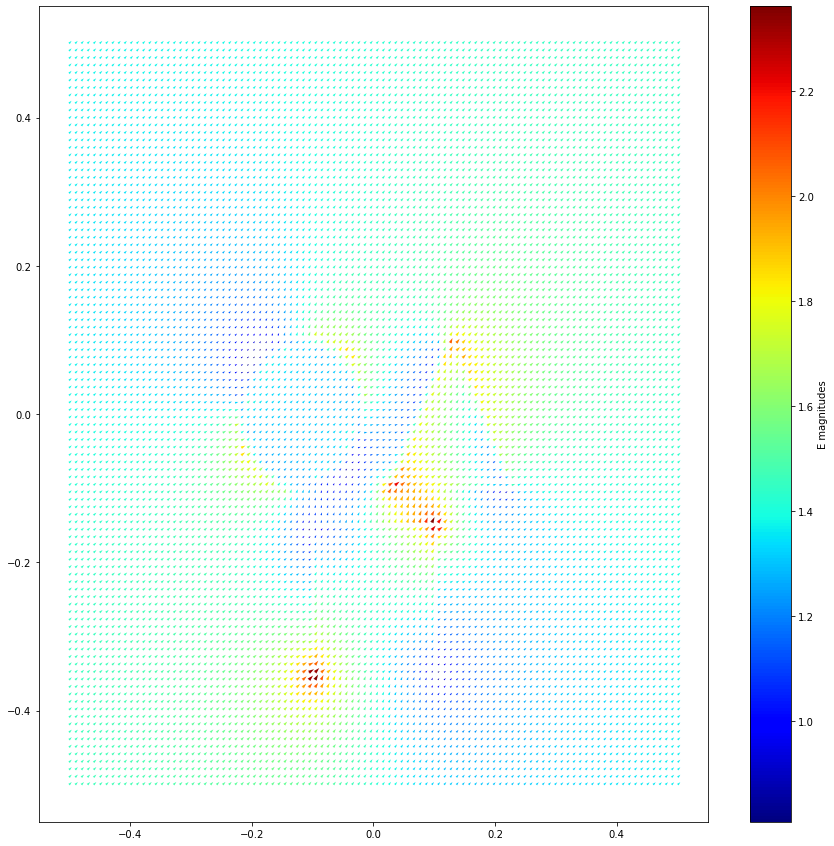

In [ ]:
map_grid, E_map = calc_E_on_grid(Nx, Ny, xy_grid, xy_grid_non_zero, Xi_mat, delta_mat, E_sol_1, E_ext)
magnitudes = np.linalg.norm(E_map, axis=0)

plt.figure(figsize=(15, 15))

nz = mcolors.Normalize()
C = np.linspace(np.min(magnitudes), np.max(magnitudes), 1000)
nz.autoscale(magnitudes)

plt.quiver(map_grid[0], map_grid[1], E_map[0], E_map[1], color=cm.jet(nz(magnitudes)).reshape(-1, 4))
cax,_ = mcolorbar.make_axes(plt.gca())
cb = mcolorbar.ColorbarBase(cax, cmap=cm.jet, norm=nz)
cb.set_label('E magnitudes')

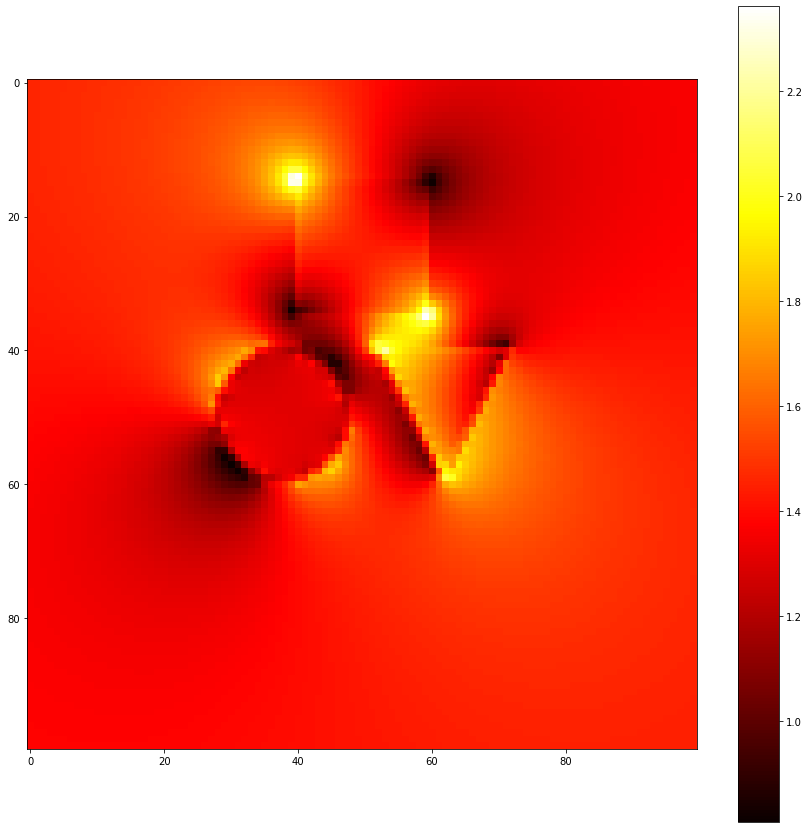

In [ ]:
plt.figure(figsize=(15, 15))

plt.imshow(magnitudes, cmap='hot', interpolation='nearest')
plt.colorbar()

# Calculate solution using Newthon method w/o given Hessian

In [ ]:
_jac = lambda E: 2 * np.mean((np.matmul(A, E.reshape(-1, 1)) - b) * A[:, :], axis=0)
E_sol_2: np.ndarray = minimize(lambda E: np.mean((np.matmul(A, E.reshape(-1, 1)) - b) ** 2), x0=b.ravel(),
                               method='Newton-CG', jac=_jac).x
E_sol_2 = E_sol_2.reshape(-1, xy_grid_non_zero.shape[0])
E_sol_2.shape, E_sol_2.dtype

((2, 910), dtype('float64'))

In [ ]:
rmse = np.sqrt(np.mean((np.matmul(A, E_sol_2.flatten().reshape(-1, 1)) - b) ** 2))
rmse

0.00014071699980287134

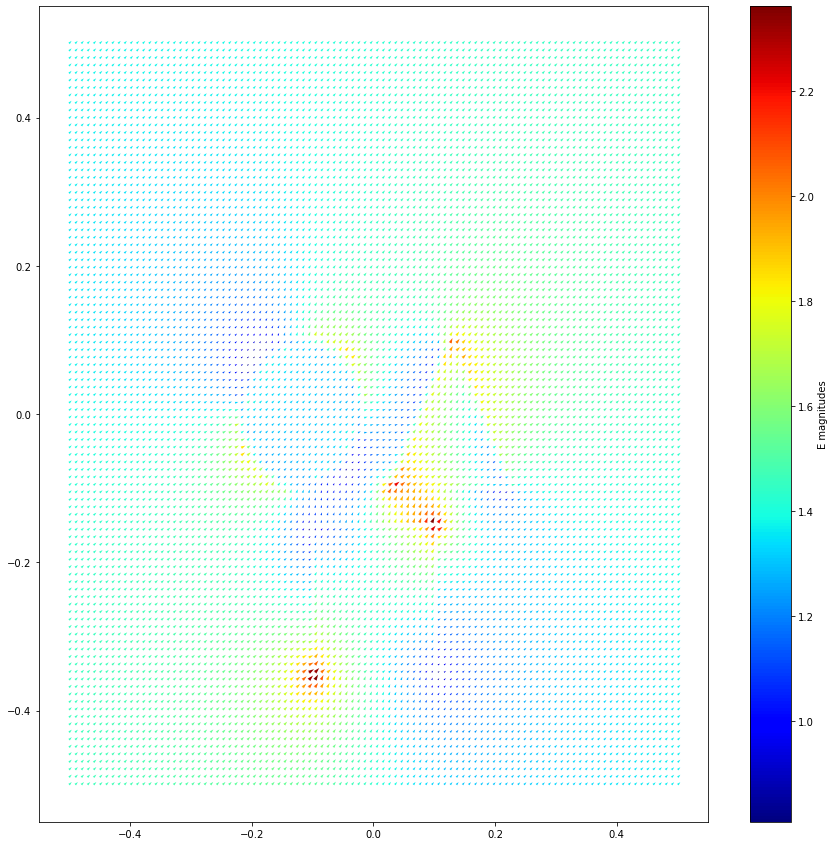

In [ ]:
map_grid, E_map = calc_E_on_grid(Nx, Ny, xy_grid, xy_grid_non_zero, Xi_mat, delta_mat, E_sol_2, E_ext)
magnitudes = np.linalg.norm(E_map, axis=0)

plt.figure(figsize=(15, 15))

nz = mcolors.Normalize()
C = np.linspace(np.min(magnitudes), np.max(magnitudes), 1000)
nz.autoscale(magnitudes)

plt.quiver(map_grid[0], map_grid[1], E_map[0], E_map[1], color=cm.jet(nz(magnitudes)).reshape(-1, 4))
cax,_ = mcolorbar.make_axes(plt.gca())
cb = mcolorbar.ColorbarBase(cax, cmap=cm.jet, norm=nz)
cb.set_label('E magnitudes')

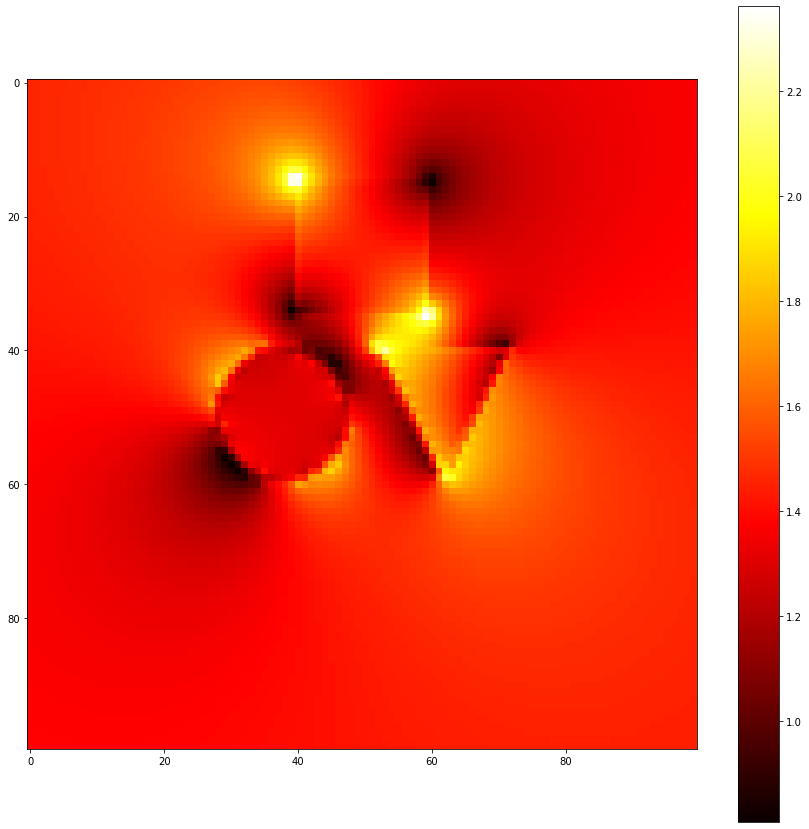

In [ ]:
plt.figure(figsize=(15, 15))

plt.imshow(magnitudes, cmap='hot', interpolation='nearest')
plt.colorbar()

# Calculate solution using Newthon method w/ given Hessian

In [ ]:
def _calc_hessian(A: np.ndarray) -> np.ndarray:
    H: np.ndarray = np.zeros_like(A)
    for ix, H_row in enumerate(H):
        H_row[:] = np.mean(A[:, ix:ix+1] * A[:, :], axis=0)
    return H

In [ ]:
_jac = lambda E: 2 * np.mean((np.matmul(A, E.reshape(-1, 1)) - b) * A[:, :], axis=0)
_hess = lambda E: _calc_hessian(A)  # 2 * np.mean(A[:, np.newaxis, :] * A[:, :, np.newaxis], axis=0)
E_sol_3: np.ndarray = minimize(lambda E: np.mean((np.matmul(A, E.reshape(-1, 1)) - b) ** 2), x0=b.ravel(),
                               method='Newton-CG', jac=_jac, hess=_hess).x
E_sol_3 = E_sol_3.reshape(-1, xy_grid_non_zero.shape[0])
E_sol_3.shape, E_sol_3.dtype

((2, 910), dtype('float64'))

In [ ]:
rmse = np.sqrt(np.mean((np.matmul(A, E_sol_3.flatten().reshape(-1, 1)) - b) ** 2))
rmse

2.3660468470894236e-05

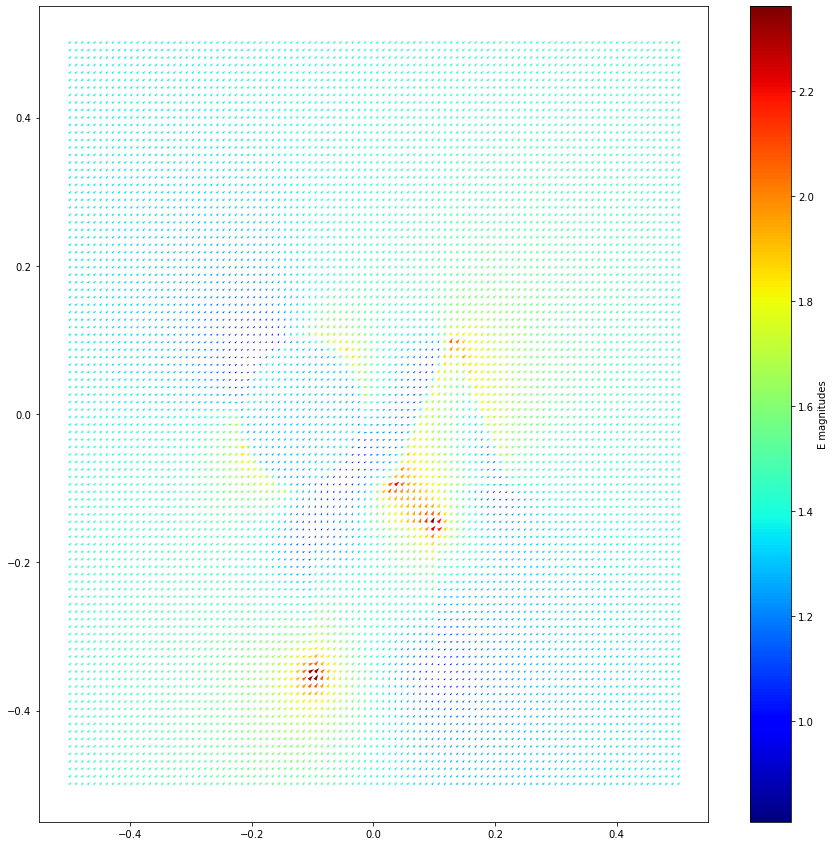

In [ ]:
map_grid, E_map = calc_E_on_grid(Nx, Ny, xy_grid, xy_grid_non_zero, Xi_mat, delta_mat, E_sol_3, E_ext)
magnitudes = np.linalg.norm(E_map, axis=0)

plt.figure(figsize=(15, 15))

nz = mcolors.Normalize()
C = np.linspace(np.min(magnitudes), np.max(magnitudes), 1000)
nz.autoscale(magnitudes)

plt.quiver(map_grid[0], map_grid[1], E_map[0], E_map[1], color=cm.jet(nz(magnitudes)).reshape(-1, 4))
cax,_ = mcolorbar.make_axes(plt.gca())
cb = mcolorbar.ColorbarBase(cax, cmap=cm.jet, norm=nz)
cb.set_label('E magnitudes')

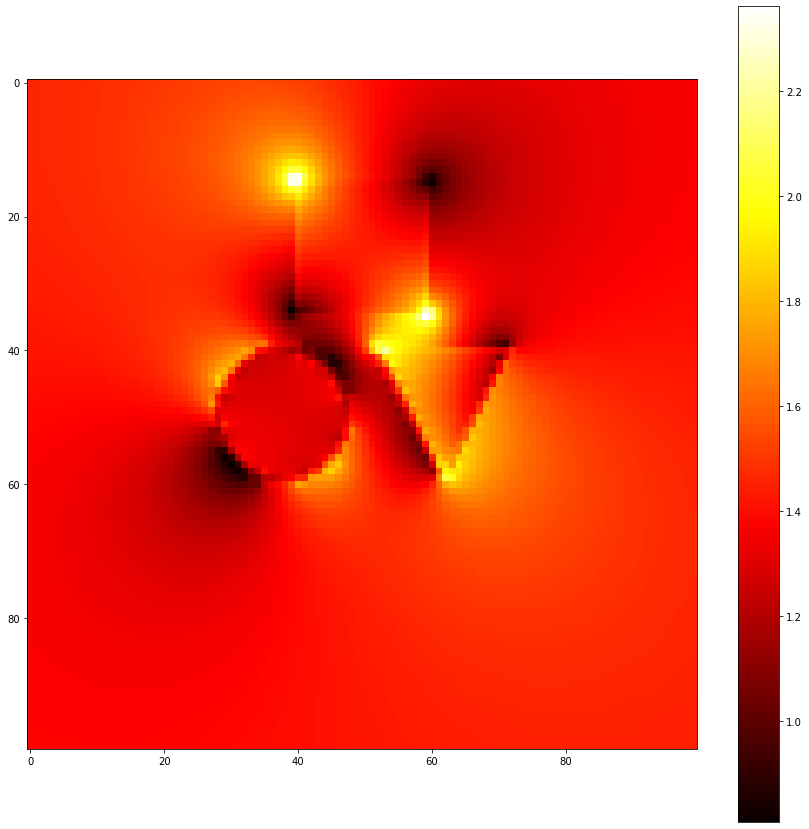

In [ ]:
plt.figure(figsize=(15, 15))

plt.imshow(magnitudes, cmap='hot', interpolation='nearest')
plt.colorbar()